In [1]:
import torch 
from torch import nn, optim
import numpy as np

import math

import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import List

In [2]:
from src.env import PuzzleEnv
from src.visualization.plotting import imshow_cube

In [3]:
device = 'cpu'

For DQN we'll use a simple FFN similar to dist_predictor

In [4]:
class DQN(nn.Module):
    def __init__(self, inp: int, oup: int, units: List[int]):
        # TODO: we can optionally add normalization layers
        super().__init__()
        layers = []
        prev = inp
        for num_units in units:
            layers.append(nn.Linear(prev, num_units))
            layers.append(nn.ReLU())
            prev = num_units

        layers.append(nn.Linear(units[-1], oup))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


DQN(inp=12, oup=24, units=[128, 128])

DQN(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=24, bias=True)
  )
)

In [5]:
class Agent:
    def __init__(self, config):
        self._load(config)

    def _load(self, config):
        self.batch_size = config["batch_size"]
        self.gamma = config["gamma"]
        self.tau = config["tau"]
        self.lr = config["lr"]
        self.weight_decay = config["weight_decay"]
        self.total_steps = config["total_steps"]

        self.epsilon_start = config["epsilon_start"]
        self.epsilon_end = config["epsilon_end"]
        self.epsilon_decay = config["epsilon_decay"]
        self.steps = 0

        self.device = device

        inp, oup, network_units = (
            config["inp"],
            config["oup"],
            config["network_units"],
        )
        self.policy_network = DQN(inp, oup, network_units).to(self.device)
        self.target_network = DQN(inp, oup, network_units).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())

        self.num_states, self.num_actions = inp, oup

        self.optimizer = optim.AdamW(
            self.policy_network.parameters(),
            lr=self.lr,
            amsgrad=True,
            weight_decay=self.weight_decay,
        )
        self.criterion = nn.SmoothL1Loss(reduction="none")

    def select_action(self, states, greedy=False):
        """Selects epsilon greedy action"""
        self.eps = self.epsilon_end + (
            self.epsilon_start - self.epsilon_end
        ) * math.exp(-1.0 * self.steps / self.epsilon_decay)
        eps = 0 if greedy else self.eps
        n = len(states)
        s = torch.rand(n, device=self.device)
        rand_actions = torch.randint(0, self.num_actions, (n,), device=self.device)
        with torch.no_grad():
            Q = self.policy_network(states)
            greedy_actions = torch.argmax(Q, dim=-1)

        return torch.where(s > eps, greedy_actions, rand_actions)

    def optimize(self, s, a, r, s_n, terminated, mask):
        with torch.no_grad():
            max_Q_s_n = self.target_network(s_n).max(axis=-1).values

        # mask out terminal states
        max_Q_s_n = torch.where(terminated == 1, torch.zeros_like(max_Q_s_n), max_Q_s_n)
        # r + gamma * max[Q(s', a)]
        target = r + self.gamma * max_Q_s_n

        # Q(s, a)
        Q = self.policy_network(s).gather(1, a.unsqueeze(-1))

        loss = self.criterion(Q, target.unsqueeze(-1))
        # apply mask on loss
        loss = torch.where(mask == 1, torch.zeros_like(loss), loss).mean()

        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()

        return loss.item()

    def update_target_net(self) -> None:
        target_sd = self.target_network.state_dict()
        policy_sd = self.policy_network.state_dict()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        for key in policy_sd:
            target_sd[key] = policy_sd[key] * self.tau + target_sd[key] * (1 - self.tau)
        self.target_network.load_state_dict(target_sd)

In [21]:
env_config = {
    "puzzle_name": "cube_3x3x3",
    "num_envs": 128,
    "max_steps": 20,
    "reset_config": {
        "sampler": "uniform",
        "shuffle_range": [1, 8],
        "extra_generation": 4,
    },
    "reward_config": {
        "success": 10,
        "time": -0.1,
    },
    "state_repr": "color",
}

env = PuzzleEnv(env_config)

agent_config = {
    "total_steps": 1000,
    "inp": env.state_size,
    "oup": env.num_actions,
    "batch_size": env.num_envs,
    "gamma": 0.99,
    "epsilon_schedule": "exp",
    "epsilon_start": 0.9,
    "epsilon_end": 0.05,
    "epsilon_decay": 2500,
    "tau": 0.005,
    "lr": 1e-,
    "weight_decay": 1e-5,
    "optimizer": "adam",
    "network_units": [128, 256, 128],
}

Loaded cube_3x3x3: 18 actions, 54 states


In [22]:
EPISODES = 1000
env = PuzzleEnv(env_config)
agent = Agent(agent_config)


history = {
    "reward": [],
    "avg_success": [],
    "loss": [],
    "success_per_n": {
        n: [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
    "success_length_per_n": {
        n: [] for n in range(*env_config["reset_config"]["shuffle_range"])
    },
}


def train(env, agent, episodes, history):
    s = env.reset()
    s = torch.tensor(s, device=device)
    for _ in tqdm(range(episodes)):
        for _ in range(env_config["max_steps"]):
            a = agent.select_action(s)
            s_n, r, terminated, mask = env.step(a)
            s_n = torch.tensor(s_n, device=device)

            loss = agent.optimize(s, a, r, s_n, terminated, mask)
            s = s_n
            agent.update_target_net()

        agent.steps += 1
        history["loss"].append(loss)
        history["reward"].append(
            env.get_cumulative_reward().sum().item() / env.num_envs
        )
        (
            success_rate_per_n,
            success_length_per_n,
            average_success,
        ) = env.get_completion_rate()
        history["avg_success"].append(average_success)
        for n in success_rate_per_n.keys():
            history["success_per_n"][n].append(success_rate_per_n[n])
            history["success_length_per_n"][n].append(success_length_per_n[n])

Loaded cube_3x3x3: 18 actions, 54 states


In [23]:
train(env, agent, episodes = 5000, history = history)
print(sum(history["avg_success"]) / len(history["avg_success"]))
print(history['avg_success'][-1])

100%|██████████| 5000/5000 [03:55<00:00, 21.26it/s]

0.21805758936383798
0.3392857143638393


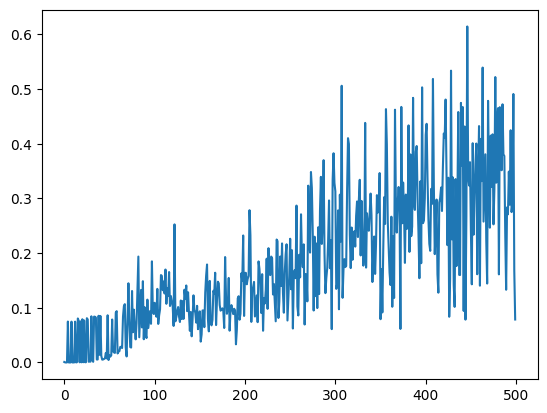

In [24]:
density = 500
gap = math.ceil(len(history["loss"]) / density)
plt.plot(history["loss"][::gap])

(0.0, 1.0)

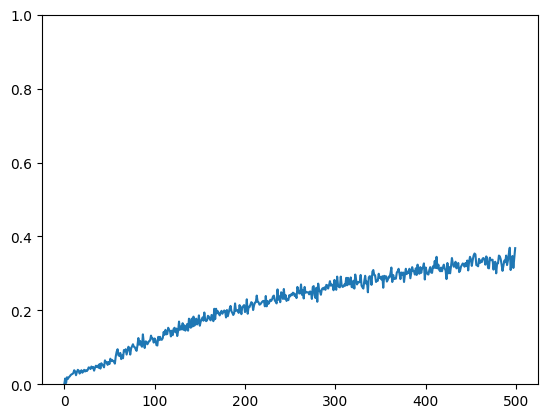

In [25]:
plt.plot(history["avg_success"][::gap])
plt.ylim(0, 1)

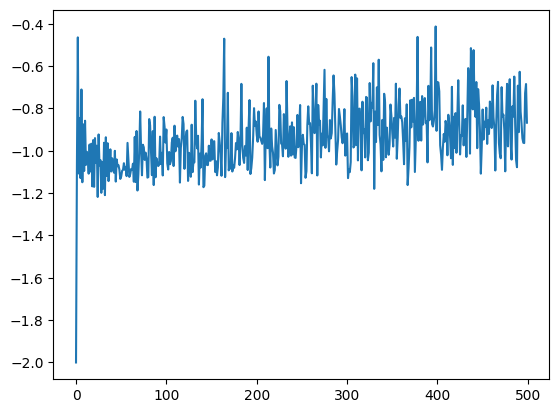

In [26]:
plt.plot(history["reward"][::gap])

(0.0, 1.0)

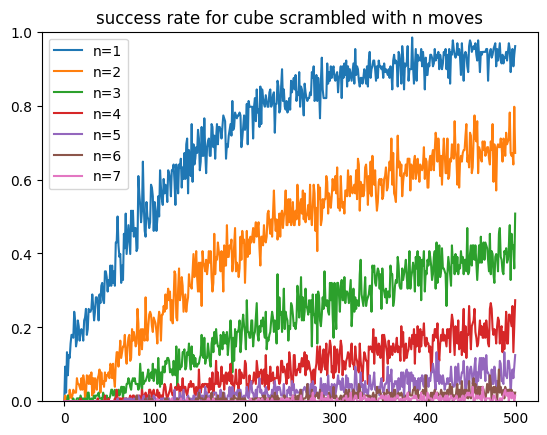

In [27]:
for n, success in history["success_per_n"].items():
    plt.plot(success[::gap], label=f'n={n}')


plt.title("success rate for cube scrambled with n moves")
plt.legend()
plt.ylim(0, 1)

In [29]:
# for n, success_length in history["success_length_per_n"].items():
#     plt.plot(success_length[::gap], label=f"n={n}")


# # plt.title("Completion length per n ")
# # plt.legend()

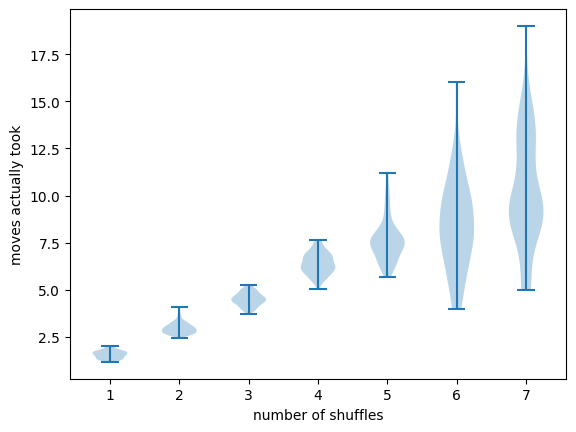

In [33]:
# take last 100 items and make a violin plot?
window = 100
# to_plot = [h[-window:] for h in history['success_length_per_n'].values()]
to_plot = [
    [n for n in h[-window:] if n != 0] for h in history["success_length_per_n"].values()
]
plt.violinplot(to_plot)
plt.ylabel("moves actually took")
plt.xlabel("number of shuffles")
plt.show()

In [32]:
history['success_length_per_n'][5]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
env_config = {
    "puzzle_name": "cube_2x2x2",
    "num_envs": 1,
    "max_steps": 5,
    "reset_config": {
        "sampler": "uniform",
        "shuffle_range": [1, 2],
    },
    "reward_config": {
        "success": 10,
        "time": -1,
    },
    "state_repr": "color",
}

env = PuzzleEnv(env_config)
env.reset()



In [ ]:
from src.mechanism.utils import get_inverse_move

sample_state = env.states[0]
sample_shuffle = env.gt_moves[0]

print(sample_shuffle)
print(env.action_names)

inv_move = get_inverse_move(sample_shuffle[0])
idx = list(env.action_names).index(inv_move)
print(f'inverse move {inv_move} on index {idx}')
env.step([idx])

In [ ]:
env.step([0])

sample_state = env.states[0]

print(env.states[0])
print(env.gt_moves[0])